## Предсказание цены на подержанные автомобили

<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Предсказание-цены-на-подержанные-автомобили" data-toc-modified-id="Предсказание-цены-на-подержанные-автомобили-1">Предсказание цены на подержанные автомобили</a></span><ul class="toc-item"><li><span><a href="#1.-Предобработка-данных" data-toc-modified-id="1.-Предобработка-данных-1.1">1. Предобработка данных</a></span></li><li><span><a href="#2.-Разведочный-анализ-данных-(EDA)" data-toc-modified-id="2.-Разведочный-анализ-данных-(EDA)-1.2">2. Разведочный анализ данных (EDA)</a></span><ul class="toc-item"><li><span><a href="#Таким-образом," data-toc-modified-id="Таким-образом,-1.2.1">Таким образом,</a></span></li></ul></li><li><span><a href="#3.-Выбор-модели" data-toc-modified-id="3.-Выбор-модели-1.3">3. Выбор модели</a></span></li><li><span><a href="#4.-Параметры-модели" data-toc-modified-id="4.-Параметры-модели-1.4">4. Параметры модели</a></span></li></ul></li></ul></div>

Датасет содержит информацию о характеристиках и ценах подержанных автомобилей.

**Описание данных:** 

**Целевая переменная**

    'selling_price' - цена продажи
    
**Метрика качества:**

    R2 > 0.8 - коэффициент детерминации

**Признаки:**
     
     name - модель автомобиля
     year - год выпуска с завода-изготовителя
     km_driven - пробег на дату продажи
     fuel - тип топлива
     seller_type - продавец
     transmission - тип трансмиссии
     owner - какой по счёту хозяин?
     mileage - пробег (расход)
     engine - рабочий объем двигателя
     max_power - пиковая мощность двигателя
     torque - крутящий момент
     seats - число мест 

In [1]:
# загружаем библиотеки 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re 
import scipy.stats

import warnings
warnings.filterwarnings("ignore")

In [2]:
path = "https://raw.githubusercontent.com/evgpat/edu_stepik_from_idea_to_mvp/main/datasets/cars.csv"

### 1. Предобработка данных

In [3]:
# загрузка данных
cars = pd.read_csv(path)

In [4]:
# случайные три записи из датасета
cars.sample(3)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
6544,BMW 6 Series GT 630d Luxury Line,2018,5830000,30000,Diesel,Individual,Automatic,First Owner,17.09 kmpl,2993 CC,261.4 bhp,620Nm@ 2000-2500rpm,4.0
737,Maruti Swift Dzire VDI,2017,620000,107000,Diesel,Individual,Manual,First Owner,28.4 kmpl,1248 CC,74.02 bhp,190Nm@ 2000rpm,5.0
5396,Maruti Ertiga ZDI,2016,725000,66000,Diesel,Dealer,Manual,First Owner,20.77 kmpl,1248 CC,88.8 bhp,200Nm@ 1750rpm,7.0


In [5]:
# информация от столбцах
cars.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6999 entries, 0 to 6998
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           6999 non-null   object 
 1   year           6999 non-null   int64  
 2   selling_price  6999 non-null   int64  
 3   km_driven      6999 non-null   int64  
 4   fuel           6999 non-null   object 
 5   seller_type    6999 non-null   object 
 6   transmission   6999 non-null   object 
 7   owner          6999 non-null   object 
 8   mileage        6797 non-null   object 
 9   engine         6797 non-null   object 
 10  max_power      6803 non-null   object 
 11  torque         6796 non-null   object 
 12  seats          6797 non-null   float64
dtypes: float64(1), int64(3), object(9)
memory usage: 711.0+ KB


**Необходимые преобразования:**

**1) Проверить на дубликаты.**

**2) Исследовать пропуски:** Присутствуют пропуски в одинаковом количестве в столбцах: mileage, engine, seats, max_power, torque.

**3) Изменить тип данных для числовых переменных.**

**4) Исследовать выбросы**

**1.1. Проверка на дубликаты**

In [6]:
print(f'Процент дубликатов: {round(cars.duplicated().sum()/len(cars) * 100)} %')

Процент дубликатов: 14 %


В данных содержится 14% дубликатов, что достаточно много, возможно, одни и те же объявления выставлялись по несколько раз. Придется удалить эти строки.

In [7]:
df = cars.drop_duplicates(keep = 'first')

**1.2. Исследование пропусков**

In [8]:
df.query('mileage != mileage').head(3)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats
12,Maruti Swift 1.3 VXi,2007,200000,80000,Petrol,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN
28,Fiat Palio 1.2 ELX,2003,70000,50000,Petrol,Individual,Manual,Second Owner,NaN,NaN,NaN,NaN,NaN
69,Tata Indica DLS,2003,50000,70000,Diesel,Individual,Manual,First Owner,NaN,NaN,NaN,NaN,NaN


Можно попытаться заполнить значениями из самой таблицы по названию модели машины, но не для всех есть данные. 

Также можно добавить информацию из других источников.

In [9]:
df[['mileage', 'engine', 'max_power', 'torque', 'seats']] = \
df.groupby(['name'])['mileage', 'engine', 'max_power', 'torque', 'seats'].apply(lambda x: x.fillna(method = 'ffill'))

In [10]:
print('Процент пропусков:', round(df['mileage'].isna().sum() / len(df) * 100, 1), '%')

Процент пропусков: 2.5 %


В данных осталось около 2.5% пропусков по характеристикам машин, можно заполнить информацией из других источников или удалить данные. Заполнить в данном случае средними значениями считаю неправильным, так как характеристики машины скорее всего будут влиять на целевую переменную.

In [11]:
# удалим значения пропусков
df = df.dropna()

**1.3. Преобразование типов данных**

**1. Mileage**

In [12]:
# проверим характеристику - расход топлива

df['mileage'].sample(10).unique()

array(['13.0 kmpl', '24.0 kmpl', '14.2 kmpl', '20.54 kmpl', '21.5 kmpl',
       '17.6 kmpl', '23.84 kmpl', '19.7 kmpl', '12.55 kmpl', '22.54 kmpl'],
      dtype=object)

В данных есть 2 вида единиц измерения: kmpl и km/kg (в зависимости от вида топлива).

In [13]:
# удалим единицы измерения
df['mileage_kmpl'] = df['mileage'].str.replace('kmpl','').str.replace('km/kg','')

# изменим тип данных
df['mileage_kmpl'] = df['mileage_kmpl'].astype('float')

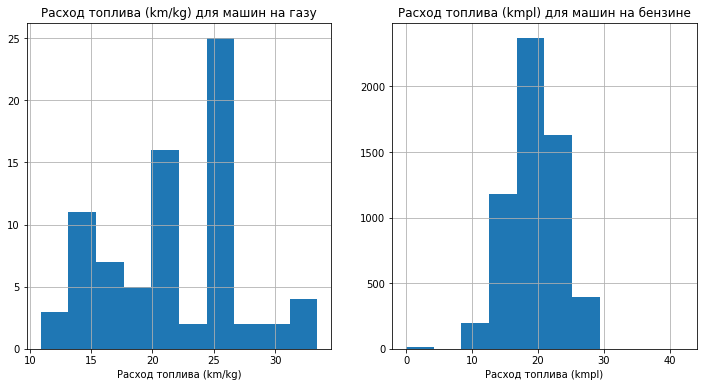

In [14]:
plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
df.loc[df['mileage'].str.contains('km/kg')]['mileage_kmpl'].hist()
plt.title('Расход топлива (km/kg) для машин на газу')
plt.xlabel('Расход топлива (km/kg)')
plt.subplot(1, 2, 2)
df.loc[df['mileage'].str.contains('kmpl')]['mileage_kmpl'].hist()
plt.title('Расход топлива (kmpl) для машин на бензине')
plt.xlabel('Расход топлива (kmpl)');

Диапазон значений почти не различается, поэтому можно оставить без преобразований.

**2. Engine**

In [15]:
# уберем единицу измерения cc - cubic centimetres
df['engine'] = df['engine'].str.replace('CC','')

# Преобразоуем тип данных 
df['engine'] = df['engine'].astype('float')

**3. Max power**

In [16]:
# уберем единицы измерения и пропуски 
df['max_power'] = df['max_power'].str.replace('bhp','')
df['max_power'] = df['max_power'].str.replace(' ','')

# преобразуем тип данных
df['max_power'] = df['max_power'].astype('float')

**4. Torque**

In [17]:
df['torque'].head(5)

0              190Nm@ 2000rpm
1         250Nm@ 1500-2500rpm
2    22.4 kgm at 1750-2750rpm
3       11.5@ 4,500(kgm@ rpm)
4           113.75nm@ 4000rpm
Name: torque, dtype: object

Значения столбца содержат крутящий момент при определенном количестве оборотов. 

Для начала нужно разделить данные на 2 столбца, затем привести к одной единицы измерения. 

In [18]:
# создадим функцию для записи первого числа - крутящего момента
def fun(x):
    try:
        return re.findall(r'[0-9.,]+', str(x))[0]
    except:
        return np.nan

In [19]:
df['torque'] = df['torque'].str.replace(',','')

df['nm'] = df['torque'].apply(lambda x: fun(x)).astype('float')

In [20]:
# функция для количества оборотов
def fun(x):
    try:
        return max(list(map(float, re.findall(r'[0-9.,]+', str(x))[1:])))
    except:
        return np.nan

In [21]:
df['rpm'] = df['torque'].apply(lambda x: fun(x))

Чтобы привести к одной единице измерения (nm) необходимо умножить, значения в kg/m на 9.8.

**1 kgm to Nm = 9.80665 Nm**

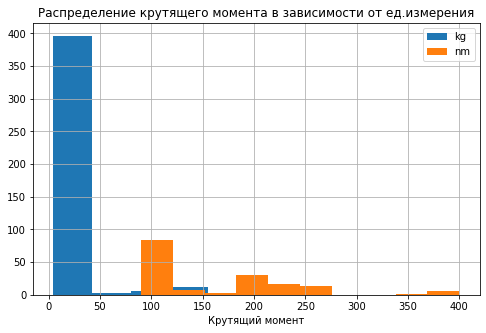

In [22]:
# проверем распределение 
plt.figure(figsize = (8, 5))
df.loc[df['torque'].str.contains('kgm|KGM', na=False)]['nm'].hist()
df.loc[df['torque'].str.contains('nm', na=False)]['nm'].hist()
plt.legend(['kg', 'nm'])
plt.title('Распределение крутящего момента в зависимости от ед.измерения')
plt.xlabel('Крутящий момент');

Видно, что значения для kg меньше, но есть выбросы на уровне nm, необходимо проверить их.

In [23]:
df.loc[(df['torque'].str.contains('kgm|KGM', na=False)) & (df['nm'] > 50)].head(3)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,mileage_kmpl,nm,rpm
526,Tata Sumo CX 10 Str BSIV,2011,175000,20000,Diesel,Individual,Manual,First Owner,12.2 kmpl,1948.0,68.00,115@ 2500(kgm@ rpm),10.0,12.2,115.0,2500.0
677,Ford Endeavour Hurricane Limited Edition,2013,1075000,110000,Diesel,Individual,Automatic,Third Owner,12.8 kmpl,2953.0,156.00,380Nm(38.7kgm)@ 2500rpm,7.0,12.8,380.0,2500.0
1038,Maruti SX4 Vxi BSIII,2007,160000,120000,Petrol,Individual,Manual,Second Owner,15.0 kmpl,1586.0,104.68,145@ 4100(kgm@ rpm),5.0,15.0,145.0,4100.0


Скорее всего ошибка в записях данных, так как если будем преобразовывать эти значения, то будут слишком высокие.

In [24]:
# преобразуем в одну единицу измерения

df.loc[(df['torque'].str.contains('kgm|KGM', na=False)) & (df['nm'] < 52), 'nm'] *= 9.80665

In [25]:
# посмотрим на преобразования 
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5865 entries, 0 to 6996
Data columns (total 16 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   name           5865 non-null   object 
 1   year           5865 non-null   int64  
 2   selling_price  5865 non-null   int64  
 3   km_driven      5865 non-null   int64  
 4   fuel           5865 non-null   object 
 5   seller_type    5865 non-null   object 
 6   transmission   5865 non-null   object 
 7   owner          5865 non-null   object 
 8   mileage        5865 non-null   object 
 9   engine         5865 non-null   float64
 10  max_power      5865 non-null   float64
 11  torque         5865 non-null   object 
 12  seats          5865 non-null   float64
 13  mileage_kmpl   5865 non-null   float64
 14  nm             5865 non-null   float64
 15  rpm            5862 non-null   float64
dtypes: float64(6), int64(3), object(7)
memory usage: 778.9+ KB


3 пропуска остались для столбца с количеством оборотов

In [26]:
df.query('rpm != rpm and nm == nm')

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,mileage_kmpl,nm,rpm
129,Volvo XC40 D4 R-Design,2018,3400000,22000,Diesel,Dealer,Automatic,First Owner,18.0 kmpl,1969.0,190.0,400Nm,5.0,18.0,400.0,NaN
361,Volvo XC40 D4 Inscription BSIV,2019,3800000,20000,Diesel,Individual,Automatic,First Owner,18.0 kmpl,1969.0,190.0,400Nm,5.0,18.0,400.0,NaN
6832,Volvo S90 D4 Inscription BSIV,2019,5500000,17000,Diesel,Individual,Automatic,First Owner,18.0 kmpl,1969.0,190.0,400Nm,5.0,18.0,400.0,NaN


Данные не заполнены для одной модели машины, заполним пропуски значением из источника: https://www.drom.ru/catalog/volvo/xc40/203261/.

**Максимальный крутящий момент, Н*м (кг*м) при об./мин. 400 (41) / 2500**

In [27]:
df.loc[(df['rpm'] != df['rpm']) & (df['nm'] == df['nm']), 'rpm'] = 2500

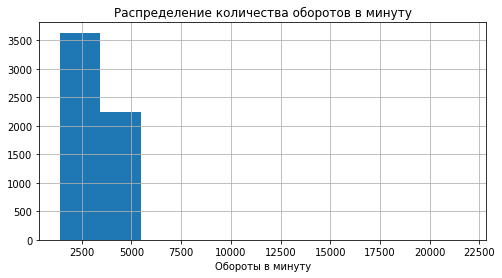

In [28]:
# проверим заполненные значения 
plt.figure(figsize = (8, 4))
df['rpm'].hist()
plt.title('Распределение количества оборотов в минуту')
plt.xlabel('Обороты в минуту');

In [29]:
# проверим выброс 
df.query('rpm > 6000')

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,mileage_kmpl,nm,rpm
4633,Tata Sumo EX TC,2005,225000,188000,Diesel,Individual,Manual,First Owner,12.3 kmpl,1948.0,90.0,190@ 21800(kgm@ rpm),7.0,12.3,190.0,21800.0


**Аномальное значение для машины,** поиск в других источниках не дал результатов по данной модели. 

Заполним значения схожим: https://www.carwale.com/used/cars-in-thanjavur/tata-sumo/s2649579/.

In [30]:
df.loc[df['rpm'] > 6000, 'rpm'] = 1800 

In [31]:
# приведем велчины к одной ед.измерения (при 7 000 оборотах)

df['torque_7000'] = df['rpm']/7000*df['nm']

**1.4. Исследование выбросов**

In [32]:
df.describe()

,year,selling_price,km_driven,engine,max_power,seats,mileage_kmpl,nm,rpm,torque_7000
count,5865.000000,5.865000e+03,5.865000e+03,5865.000000,5865.000000,5865.000000,5865.000000,5865.000000,5865.000000,5865.000000
mean,2013.626087,5.298927e+05,7.337186e+04,1430.163001,87.738724,5.436658,19.507059,171.358563,3036.221313,69.499031
std,3.886017,5.365670e+05,5.994117e+04,490.217705,31.979843,0.991154,4.053701,84.867938,891.014205,31.557034
min,1994.000000,2.999900e+04,1.000000e+00,624.000000,0.000000,2.000000,0.000000,47.071920,1400.000000,19.963538
25%,2011.000000,2.500000e+05,3.700000e+04,1197.000000,67.100000,5.000000,16.800000,111.700000,2250.000000,48.214286
50%,2014.000000,4.200000e+05,6.900000e+04,1248.000000,81.830000,5.000000,19.600000,160.000000,3000.000000,61.285714
75%,2017.000000,6.500000e+05,1.000000e+05,1498.000000,100.000000,5.000000,22.540000,200.055660,4000.000000,86.310714
max,2020.000000,1.000000e+07,2.360457e+06,3604.000000,400.000000,14.000000,42.000000,789.000000,5300.000000,269.285714


1. **Большая часть машин относится к 2011 - 2020 гг., минимальный год - 1994.**
2. Распределение цены имеет слишком высокие выбросы, **среднее значение цены - 530 000, медиана 420 000. Диапазон цен от 30 000 до 10 000 000.**
3. Значение пробега имеет выбросы, среднее значение - 73 000 км, медиана 69 000 км.
4. Рабочий объем двигателя в среднем 1 430 CC, скорее всего есть выбросы.
5. Значение пиковой мощности находится в пределах от 0 до 400, необходимо проверить данные.
6. **Количество мест распределено от 2 до 14, больше всего машин на 5 мест.**
7. Значение расхода топлива находятся в диапазоне от 0 до 42, скорее всего есть выбросы.
8. Значение крутящего момента имеет выбросы.

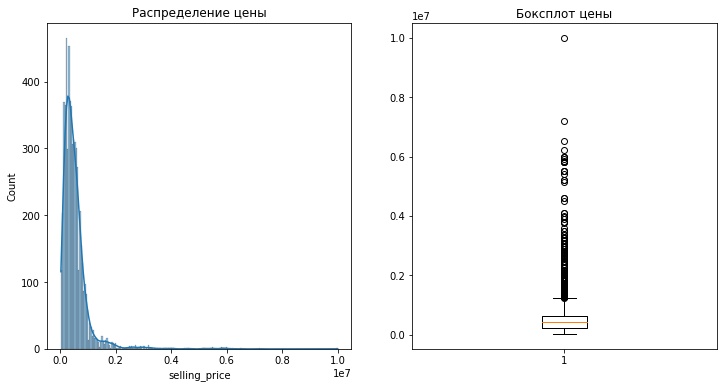

In [33]:
# рассмотрим распределение цены 

plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['selling_price'], kde = True)
plt.title('Распределение цены')
plt.subplot(1, 2, 2)
plt.boxplot(data = df, x = 'selling_price')
plt.title('Боксплот цены');

**Распределение сильно отличается от нормального.**

Значения выше 1,5 млн. считаются выбросами. Значение около 10 000 000 находится слишком далеко от выбросов.

In [34]:
df.query('selling_price > 7000000').head(3)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,mileage_kmpl,nm,rpm,torque_7000
151,Volvo XC90 T8 Excellence BSIV,2017,10000000,30000,Petrol,Individual,Automatic,First Owner,42.0 kmpl,1969.0,400.0,640Nm@ 1740rpm,4.0,42.00,640.0,1740.0,159.085714
2532,BMW X7 xDrive 30d DPE,2020,7200000,5000,Diesel,Individual,Automatic,First Owner,13.38 kmpl,2993.0,265.0,620Nm@ 1500-2500rpm,7.0,13.38,620.0,2500.0,221.428571


Скорее всего данные правильные и такие машины могут иметь такую цену. **Можно удалить выброс в 10 000 000.**

In [35]:
df = df.query('selling_price < 9000000')

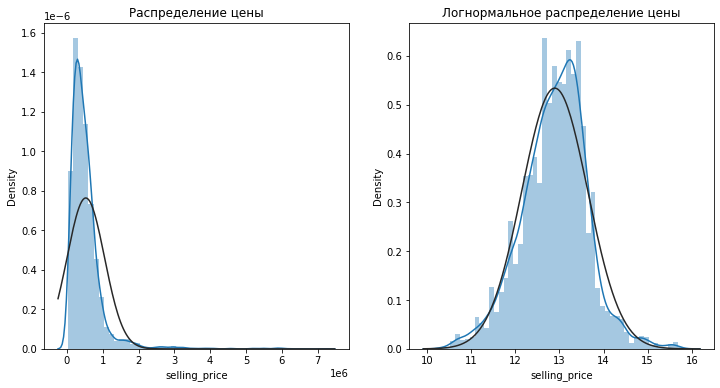

In [36]:
# построим логнормальное распределение для цены
plt.figure(figsize =(12, 6))
plt.subplot(1, 2, 1)
sns.distplot(df['selling_price'], kde = True, fit = scipy.stats.norm)
plt.title('Распределение цены')
plt.subplot(1, 2, 2)
sns.distplot(np.log(df['selling_price']), kde = True, fit = scipy.stats.norm)
plt.title('Логнормальное распределение цены');

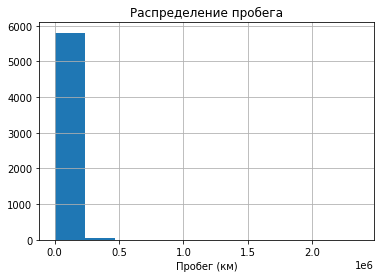

In [37]:
# распределение пробега

df['km_driven'].hist()
plt.title('Распределение пробега')
plt.xlabel('Пробег (км)');

In [38]:
# проверим выброс
df.query('km_driven > 1000000')

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,mileage_kmpl,nm,rpm,torque_7000
1551,Mahindra XUV500 W6 2WD,2012,500000,1500000,Diesel,Individual,Manual,First Owner,15.1 kmpl,2179.0,140.00,330Nm@ 1600-2800rpm,7.0,15.1,330.0,2800.0,132.000000
3003,Hyundai i20 Asta 1.2,2007,550000,2360457,Petrol,Individual,Manual,Second Owner,18.6 kmpl,1197.0,81.83,114.7Nm@ 4000rpm,5.0,18.6,114.7,4000.0,65.542857


Выглядит подозрительно, но наверное это возможно.

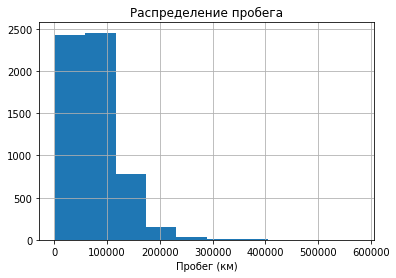

In [39]:
df.query('km_driven > 1 and km_driven < 1000000')['km_driven'].hist()
plt.title('Распределение пробега')
plt.xlabel('Пробег (км)');

**Для большинства машин пробег до 110 000 км.**

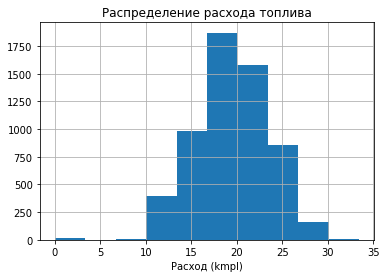

In [40]:
# распределение расхода топлива

df['mileage_kmpl'].hist()
plt.title('Распределение расхода топлива')
plt.xlabel('Расход (kmpl)');

**Распределение для большинства от 10 до 30 kmpl**, но есть значения 0.

In [41]:
df.query('mileage_kmpl == 0').head(2)

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,mileage_kmpl,nm,rpm,torque_7000
561,Tata Indica Vista Aura Safire Anniversary Edition,2009,135000,28900,Petrol,Individual,Manual,Second Owner,0.0 kmpl,1172.0,65.0,9.8@ 3000(kgm@ rpm),5.0,0.0,96.10517,3000.0,41.187930
1411,Hyundai Santro Xing GL,2008,105000,128000,Petrol,Individual,Manual,First Owner,0.0 kmpl,1086.0,62.0,96.1Nm@ 3000rpm,5.0,0.0,96.10000,3000.0,41.185714


Скорее всего ошибка в данных, можно заполнить из других источников, но пока удалим.

In [42]:
df = df.query('mileage_kmpl > 0')

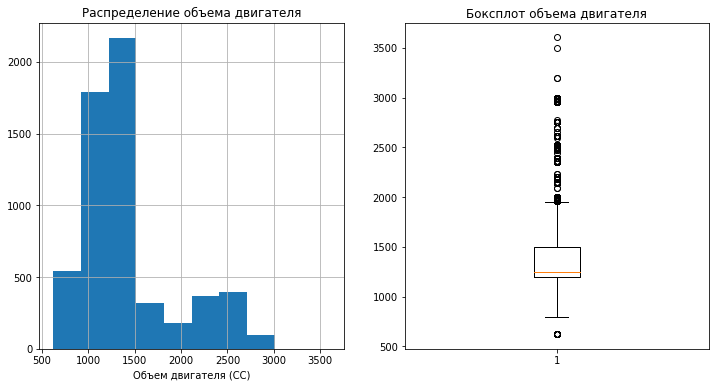

In [43]:
# распределение объема двигателя

plt.figure(figsize = (12, 6))
plt.subplot(1, 2, 1)
df['engine'].hist()
plt.title('Распределение объема двигателя')
plt.xlabel('Объем двигателя (CC)')
plt.subplot(1, 2, 2)
plt.boxplot(data = df, x = 'engine')
plt.title('Боксплот объема двигателя');

По графику "ящик с усами" видно, что выбросы начинаются от 2 000, но поиск в источниках показал, что такие значения могут быть.

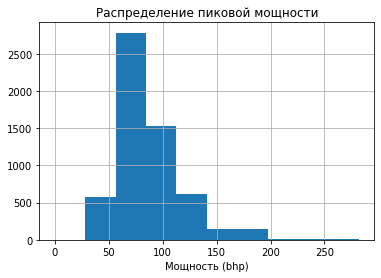

In [44]:
df['max_power'].hist()
plt.title('Распределение пиковой мощности')
plt.xlabel('Мощность (bhp)');

In [45]:
df.query('max_power == 0')

,name,year,selling_price,km_driven,fuel,seller_type,transmission,owner,mileage,engine,max_power,torque,seats,mileage_kmpl,nm,rpm,torque_7000
503,Maruti Alto K10 LXI,2011,204999,97500,Petrol,Individual,Manual,First Owner,20.92 kmpl,998.0,0.0,90Nm@ 3500rpm,5.0,20.92,90.0,3500.0,45.000000
2196,Tata Indica Vista Quadrajet LS,2012,240000,70000,Diesel,Individual,Manual,First Owner,22.3 kmpl,1248.0,0.0,190Nm@ 1750-3000rpm,5.0,22.30,190.0,3000.0,81.428571


Приведенная к одной ед.измерения величина torque_7000 соотносится с max_power, поэтому заполним этим значением.

In [46]:
df.loc[df['max_power'] == 0, 'max_power'] = (df['nm'] * df['rpm'])/5252

**Большинство значений находятся в диапазоне от 50 до 150.**

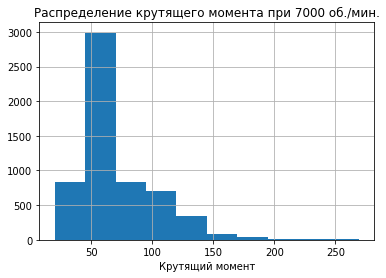

In [47]:
# распределение крутящего момента

df['torque_7000'].hist()
plt.title('Распределение крутящего момента при 7000 об./мин.')
plt.xlabel('Крутящий момент');

**Проверим категориальные переменные.**

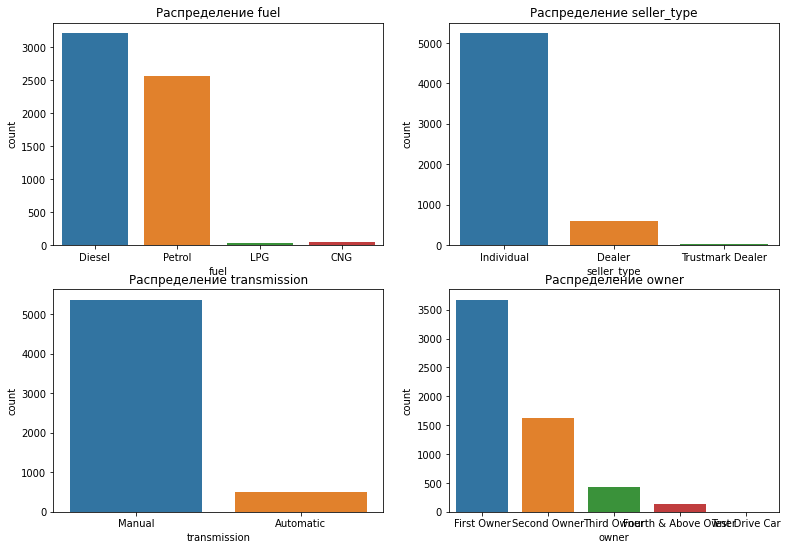

In [48]:
columns = ['fuel', 'seller_type', 'transmission', 'owner']
plt.figure(figsize = (13, 9))
for i,column in enumerate(columns): 
    ax = sns.countplot(df[column], ax = plt.subplot (2, 2, i + 1))
    plt.title(f'Распределение {column}');

**1) Большинство машин на дизельном топливе и бензине,** другие 2 категории - LPG и CNG можно объединить в одну переменную.

**2) Более 90% объявлений от пользователей.** Dealer и Trustmark Dealer можно также объединить.

**3) Большая часть машин на механической коробке передач.**

**4) Больше всего объявлений от первого владельца,** затем величина постепенно убывает с количеством владельцев.

### 2. Разведочный анализ данных (EDA)

Рассмотрим, какие категориальные переменные влияют на медиану цены.

In [49]:
# функция для графиков
def boxplot_cat(column):
    plt.figure(figsize = (8, 5))
    sns.boxplot(data = df[df.selling_price < df.selling_price.quantile(.99)], x = column, y = 'selling_price')
    plt.grid()
    plt.title(f'Распределение цены в зависимости от {column}');

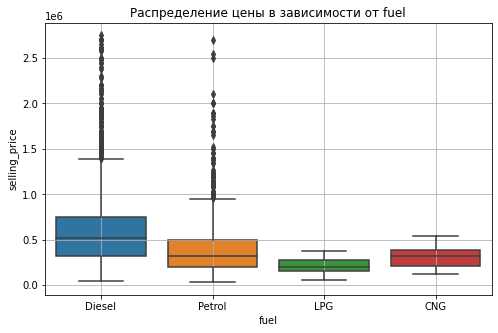

In [50]:
boxplot_cat('fuel')

Медиана цены для машин с дизельным топливом выше, чем для машин с бензином.  

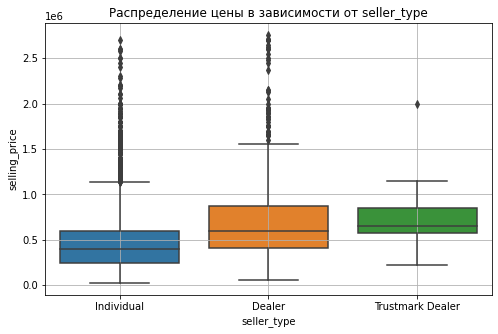

In [51]:
boxplot_cat('seller_type')

**Медиана цены выше для машин, которые продаются дилерами,** 2 категории с дилерами можно объединить в одну группу. 

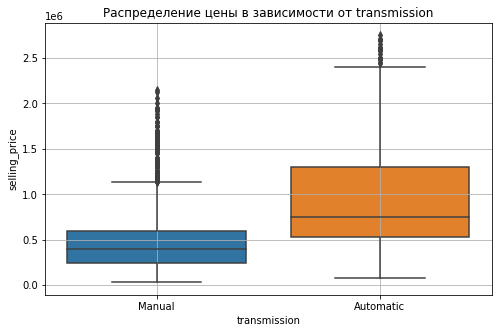

In [52]:
boxplot_cat('transmission')

**Машины на автоматической коробке передач сильно превосходят по цене машины с механической коробкой.**

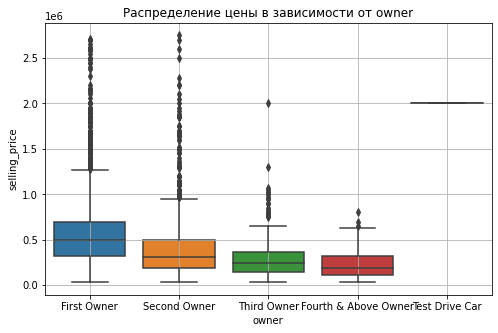

In [53]:
boxplot_cat('owner')

**Наибольшая медиана цены для машин с первым владельцем**, затем медиана цены постепенно снижается с увеличением числа владельцев. Также сильно выделяется Test Drive Car, но их значений очень мало, поэтому объединим их с First Owner.

**Преобразование переменных:**

In [54]:
df.loc[(df['fuel'] == "CNG") | (df['fuel'] == "LPG"), 'fuel'] = 'Others'
df = pd.get_dummies(df, columns=['fuel'], drop_first=True)

df.loc[df['seller_type'] == "Trustmark Dealer", 'seller_type'] = 'Dealer'
df = pd.get_dummies(df, columns=['seller_type'], drop_first=True)

df = pd.get_dummies(df, columns=['transmission'], drop_first=True)

df.loc[df["owner"].str.contains("Second Owner|Third Owner|Fourth & Above Owner"), 'owner'] = 'Second'
df.loc[df["owner"] == "Test Drive Car", 'owner'] = 'First Owner'
df = pd.get_dummies(df, columns=['owner'], drop_first=True)

In [55]:
# преобразование целевой переменной
df['log_price'] = np.log(df['selling_price'])

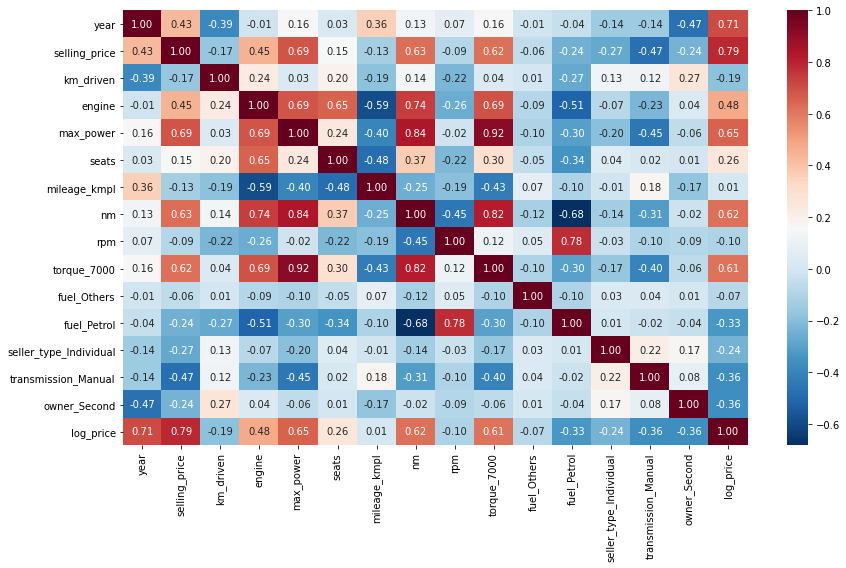

In [56]:
plt.figure(figsize = (14, 8))
sns.heatmap(df.corr(), annot = True, fmt='.2f', cmap='RdBu_r');

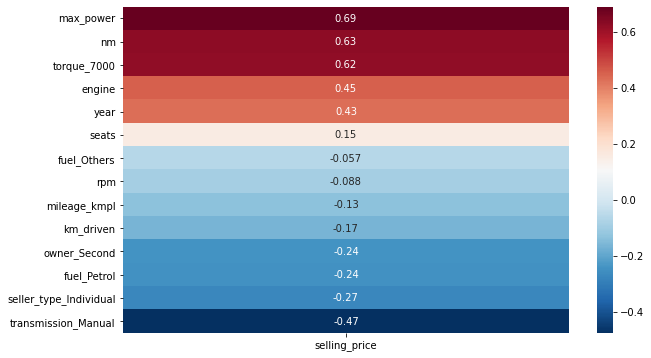

In [57]:
# построим корр. матрицу только для целевой переменной
corr_price = df.corr().iloc[1:2].T

plt.figure(figsize = (10, 6))
sns.heatmap(corr_price.sort_values(by = 'selling_price', ascending = False).\
            drop(['selling_price', 'log_price']), annot = True, fmt='.2g', cmap='RdBu_r');

**Корреляция с целевой переменной (ценой):**
    
По шкале Чеддока: 
1) Заметная положительная корреляция **с пиковой мощностью (0.69)**
    
2) Заметная положительная корреляция **с крутящим моментом (0.63)**
    
3) Умеренная положительная корреляция **с объемом двигателя (0.46)**
     
4) Умеренная положительная корреляция **с годом (0.43)**

5) Умеренная отрицательная **с типом коробки передач (-0.48)**

Видна разница в корреляции между значением цены и ее логарифмом: корреляция по году для логарифма намного больше.

Также есть переменные, которые имеют высокую степень корреляции между собой, например:

**Сильная положительная корреляция между пиковой мощностью и крутящим моментом** (после приведения к 7000 об./в мин. эти 2 величины обозначают одно и то же).

**Предположительно, на цену в большей степени будут влиять: пиковая мощность и год.**

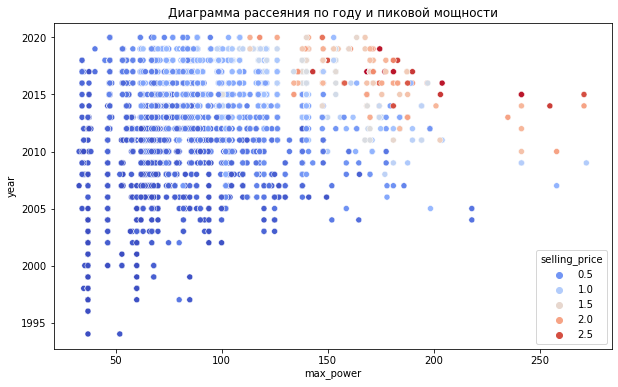

In [58]:
plt.figure(figsize = (10, 6))
sns.scatterplot(data = df[df.selling_price < df.selling_price.quantile(.99)], x = 'max_power', y = 'year', hue = 'selling_price', \
                palette = 'coolwarm')
plt.title('Диаграмма рассеяния по году и пиковой мощности');

**С увеличением пиковой мощности и года выпуска увеличивается стоимость.**

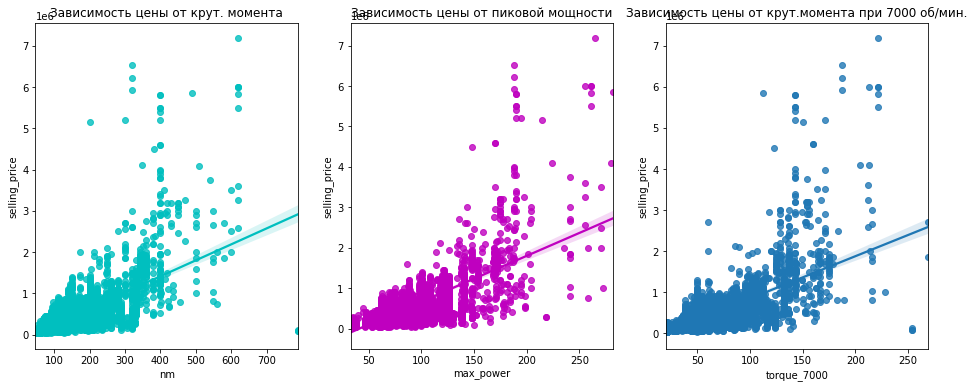

In [59]:
plt.figure(figsize = (16, 6))
plt.subplot(1, 3, 1)
sns.regplot(x='nm',y='selling_price',data=df, color = 'c')
plt.title('Зависимость цены от крут. момента')
plt.subplot(1, 3, 2)
sns.regplot(x='max_power',y='selling_price',data=df, color = 'm')
plt.title('Зависимость цены от пиковой мощности')
plt.subplot(1, 3, 3)
sns.regplot(x='torque_7000',y='selling_price',data=df)
plt.title('Зависимость цены от крут.момента при 7000 об/мин.');

Все 3 величины достаточно сильно коррелируют между собой и описывают одну и ту же характеристику. Оставим, только max_power, так как больше всего коррелирует с ценой.

**Все 3 величины плохо объясняют высокие значения цены.**

Посмотрим, как различаются цены на машины выше 99 перцентиля по цене.

In [60]:
def kde_plot(column):
    plt.figure(figsize = (8, 6))
    sns.histplot(df[df.selling_price < df.selling_price.quantile(.99)][column], kde = True, \
             stat = 'density', alpha = 0.3, bins = 10)
    sns.histplot(df[df.selling_price >= df.selling_price.quantile(.99)][column], kde = True, stat = 'density', \
             alpha = 0.3, bins = 10, color = 'r')
    plt.title(f'Распределение {column} в зависимости от ценового сегмента')
    plt.xlabel(column)
    plt.legend(['Средний', 'Высокий']);

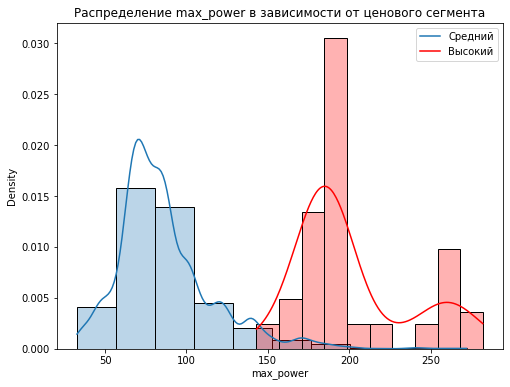

In [61]:
kde_plot('max_power')

Видно, что пиковая мощность для высокого сегмента начинается от 150, для среднего сегмента значения выше 150 встречаются редко.

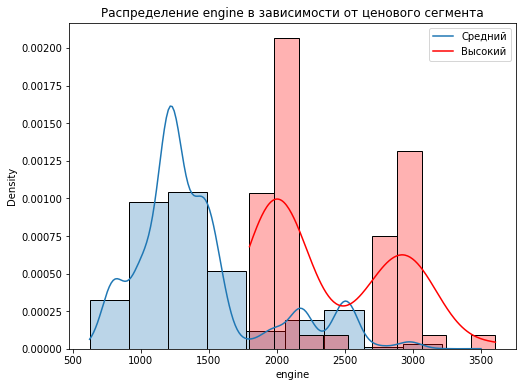

In [62]:
kde_plot('engine')

Объем двигателя также выше для высокого сегмента. Для среднего сегмента пик около 1300, для высокого 2 пика: 2000 и 3000.

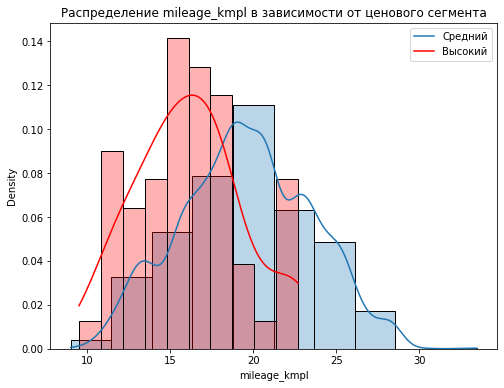

In [63]:
kde_plot('mileage_kmpl')

По расходу средний сегмент имеет более высокие показатели. 

In [64]:
# выделим бренды машин с высокой стоимостью 
df['brand'] = df['name'].apply(lambda x: re.findall(r'\w+', str(x))[0])

df[df.selling_price >= df.selling_price.quantile(.99)].groupby('brand')['brand'].count()

brand
Audi         9
BMW         20
Ford         1
Jaguar       3
Jeep         1
Land         1
Lexus        1
Mercedes    11
Toyota       9
Volvo        3
Name: brand, dtype: int64

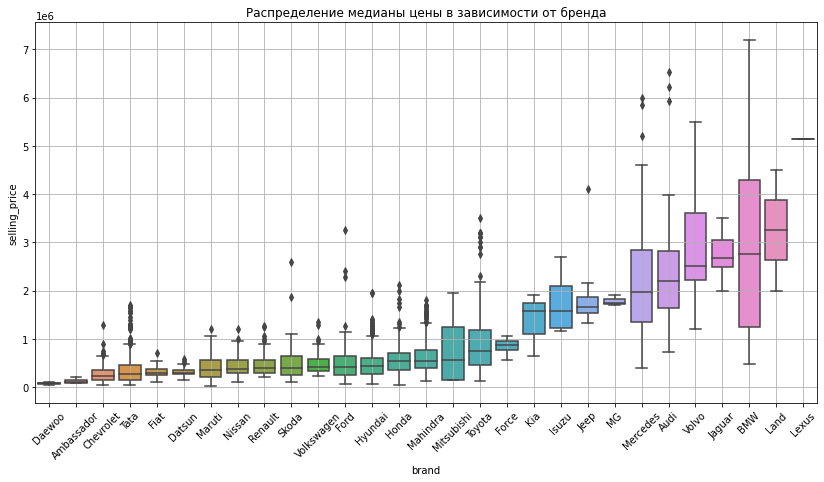

In [65]:
# график медианой цены для брендов для выделения сегментов
order = df.groupby('brand')['selling_price'].agg({'mean', 'median'})\
.sort_values(by = 'median').reset_index()['brand'].to_list() # задаем порядок

plt.figure(figsize = (14, 7))
sns.boxplot(data = df, y = 'selling_price', x = 'brand', order = order)
plt.grid()
plt.title(f'Распределение медианы цены в зависимости от бренда')
plt.xticks(rotation = 45);

#### Таким образом, 

Можно выделить некоторые зависимости в характеристиках машин и цены: 

1) На цену в большей степени влияет пиковая мощность автомобиля. **Чем выше пикова мощность, тем выше цена.**

2) На цену влияет год выпуска машины. **Чем больше год, тем выше цена**.

3) На цену влияет объем двигателя. Для среднего сегмента пик около 1300, для высокого 2 пика: 2000 и 3000. **Чем больше объем двигателя, тем выше цена.**

4) **Цены на машины с дизельным топливом выше, чем на машины с бензином.**

5) **Цена на машины от диллеров выше, чем от пользователей.**

6) **Цена выше для машин с автоматической трансмиссией.**

7) **Цена выше для машин с 1 владельцем и на Test drive машины.**

8) Все представленные величины плохо отслеживает слишком высокие значения, которые представлены брендами класса выше. **Так как машины поддержанные и соответственно разных годов, сложно выделить сегменты по брендам.** (Так же в данных представлены лишь определенные модели машин).

### 3. Выбор модели

In [66]:
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn import linear_model, ensemble
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error

In [67]:
# запишем целевую переменную
y = df['log_price']

# признаки
X = df.drop(['selling_price', 'name', 'torque', 'mileage', 'log_price', 'torque_7000', 'rpm', 'nm', 'brand'],  axis=1)

In [68]:
X.head(3)

,year,km_driven,engine,max_power,seats,mileage_kmpl,fuel_Others,fuel_Petrol,seller_type_Individual,transmission_Manual,owner_Second
0,2014,145500,1248.0,74.00,5.0,23.40,0,0,1,1,0
1,2014,120000,1498.0,103.52,5.0,21.14,0,0,1,1,1
2,2010,127000,1396.0,90.00,5.0,23.00,0,0,1,1,0


In [69]:
# разделим выборку на тренировочную и тестовую
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state = 35)

X_train.shape, X_test.shape

((4387, 11), (1463, 11))

In [70]:
# стандартизируем величины - пришлось убрать, так как входные данные в streamlit не знаю, как обработать
#ss = StandardScaler()
#X_train = ss.fit_transform(X_train)
#X_test = ss.transform(X_test)

**Будем проверять метрики на 3-х моделях: Линейной регрессии, Случайный лес и Градиентный бустинг.**

**MAE** - средняя абсолютная ошибка 

**RMSE** - среднеквадратическая ошибка (Более чувствителен к выбросам)

**MAPE** - cредняя абсолютная процентная ошибка

**R2** - коэффициент детерминации (насколько модель хорошо объясняет данные)

In [71]:
def model_test(model):
    model = model # создаем модель
    
    model.fit(X_train, y_train) # обучаем модель
    
    pred_test = model.predict(X_test)
    pred_train = model.predict(X_train)
    pred_test = np.exp(pred_test) 
    pred_train = np.exp(pred_train)
    
    print(f'Минимальная цена: {round(min(pred_test))}, максимальная цена: {round(max(pred_test))}')
    
    print(f'MAPE: {round(mean_absolute_percentage_error(np.exp(y_test), pred_test), 3)}')
    
    print("MAE: {0:7.2f}, RMSE: {1:7.2f} для тестовой модели".format(
        mean_absolute_error(np.exp(y_test), pred_test), 
        np.sqrt(mean_squared_error(np.exp(y_test), pred_test))))
    
    print('r2 для test:', round(r2_score(np.exp(y_test), pred_test), 3), \
          ', r2 для train:', round(r2_score(np.exp(y_train), pred_train), 3))
    
    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.scatter(np.exp(y_test), pred_test)  # рисуем точки, соответствущие парам настоящее значение - прогноз
    plt.plot([0, 6 * 10**6], [0, 6 * 10**6]) # рисуем прямую, на которой предсказания и настоящие значения совпадают
    plt.title('Предсказания цены для выборки test')
    plt.xlabel('Настоящая цена', fontsize=20)
    plt.ylabel('Предсказанная цена', fontsize=20)
        
    plt.subplot(1, 2, 2)
    plt.scatter(np.exp(y_train), pred_train) 
    plt.plot([0, 6 * 10**6], [0, 6 * 10**6])
    plt.title('Предсказания цены для выборки train')
    plt.xlabel('Настоящая цена', fontsize=20)
    plt.ylabel('Предсказанная цена', fontsize=20)

Минимальная цена: 24554, максимальная цена: 5105555
MAPE: 0.242
MAE: 119265.74, RMSE: 250507.10 для тестовой модели
r2 для test: 0.766 , r2 для train: 0.815


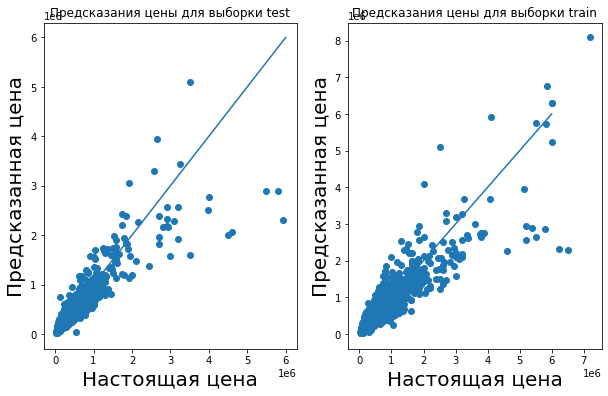

In [72]:
model_test(linear_model.LinearRegression())

Линейная модель хорошо определила диапазон значений. R2 для тестовой выборки находится на хорошем уровне.

Минимальная цена: 42385, максимальная цена: 5549540
MAPE: 0.174
MAE: 84081.70, RMSE: 178496.12 для тестовой модели
r2 для test: 0.881 , r2 для train: 0.984


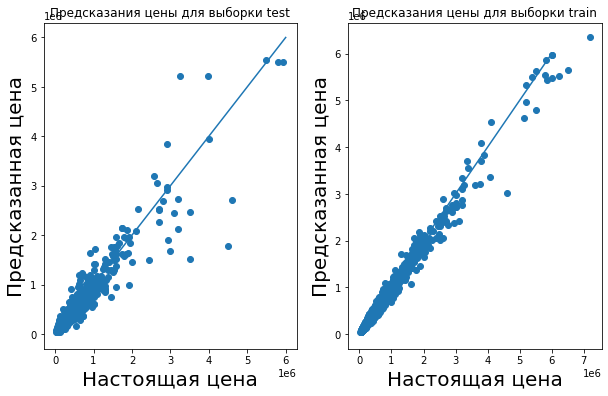

In [73]:
model_test(ensemble.RandomForestRegressor())

Все метрики лучше, чем для линейной регрессии, но модель так же плохо предсказывает слишком высокие значения.

Минимальная цена: 50139, максимальная цена: 5130042
MAPE: 0.189
MAE: 90673.90, RMSE: 176944.03 для тестовой модели
r2 для test: 0.883 , r2 для train: 0.918


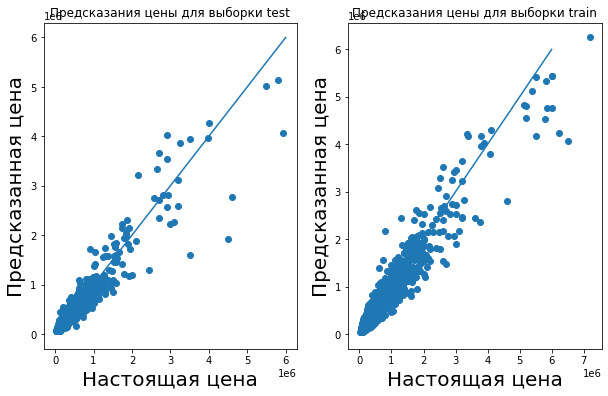

In [74]:
model_test(GradientBoostingRegressor())

Метрики схожи с моделью случайного леса, но модель лучше предсказывает выбросы.

**Лучшие значения метрик для модели - ensemble.RandomForestRegressor()**, но можно так же подобрать параметры к модели Градиентного бустинга.

### 4. Параметры модели

**1. Модель RandomForestRegressor()**

In [75]:
from sklearn.model_selection import RandomizedSearchCV

In [76]:
# попробуем подобрать наилучшие параметры для модели
model = ensemble.RandomForestRegressor()

param_distributions = {'n_estimators': [100, 200, 300, 500],   
                       'max_depth': [3, 5, 7, 15, 17],
                       'min_samples_split': [2, 5, 8],
                       'min_samples_leaf': [1, 2, 4]}
                       
random_search = RandomizedSearchCV(model, param_distributions, n_iter=10, cv=5, return_train_score=True)  

random_search.fit(X_train, y_train)  

y_pred = random_search.predict(X_test) 

print("Лучшие параметры:", random_search.best_params_)  

Лучшие параметры: {'n_estimators': 500, 'min_samples_split': 8, 'min_samples_leaf': 1, 'max_depth': 17}


In [88]:
model = ensemble.RandomForestRegressor(max_depth = 17, min_samples_leaf = 1, min_samples_split = 2, n_estimators = 500)

In [89]:
model.fit(X_train, y_train)

RandomForestRegressor(max_depth=17, n_estimators=500)

In [90]:
y_pred = model.predict(X_test)

In [91]:
print(f'Минимальная цена: {round(min(np.exp(y_pred)), 2)} максимальная цена: {round(max(np.exp(y_pred)), 2)}')
print('MAE', round(mean_absolute_error(np.exp(y_test), np.exp(y_pred)), 2), '\n'
      'RMSE', round(np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred))), 2), '\n' 
       'R2', round(r2_score(np.exp(y_test), np.exp(y_pred)), 2))

Минимальная цена: 42627.73 максимальная цена: 5522116.2
MAE 82791.47 
RMSE 173696.7 
R2 0.89


**2. Модель GradientBoostingRegressor()**

In [81]:
model_gr = GradientBoostingRegressor(learning_rate=0.2, n_estimators=300, min_samples_split = 2)

In [82]:
model_gr.fit(X_train, y_train)

GradientBoostingRegressor(learning_rate=0.2, n_estimators=300)

In [83]:
y_pred_gr = model_gr.predict(X_test)

In [84]:
print(f'Минимальная цена: {round(min(np.exp(y_pred_gr)), 2)} максимальная цена: {round(max(np.exp(y_pred_gr)), 2)}')
print('MAE', round(mean_absolute_error(np.exp(y_test), np.exp(y_pred_gr)), 2), '\n'
      'RMSE', round(np.sqrt(mean_squared_error(np.exp(y_test), np.exp(y_pred_gr))), 2), '\n' 
       'R2', round(r2_score(np.exp(y_test), np.exp(y_pred_gr)), 3))

Минимальная цена: 34491.18 максимальная цена: 6344556.46
MAE 79434.57 
RMSE 155286.29 
R2 0.91


**После подбора параметром у модели Градиентного бустинга метрики стали лучше.** Посмотрим на распределение признаков по важности.

In [85]:
# запишем таблицу с признаками по важности
importances = pd.DataFrame(data={
    'Признак': X.columns,
    'Важность_rand_forest': model.feature_importances_, 
    'Важность grad_boost': model_gr.feature_importances_
})

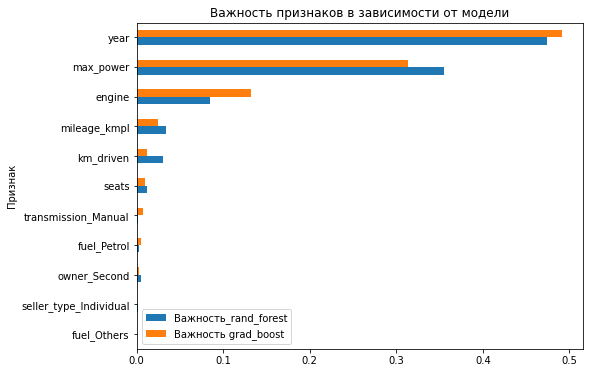

In [86]:
ax = importances.sort_values(by = 'Важность grad_boost').\
plot.barh(x='Признак', y=['Важность_rand_forest', 'Важность grad_boost'], figsize = (8, 6))
plt.title('Важность признаков в зависимости от модели');

Заметны некоторые различия в значениях важности по признакам. Например, в модели град.бустинга боьше учтены объем двигателя, вид трансмиссии, вид топлива.

**Топ 3-признака по важности: год, пиковая мощность и объем двигателя.**

In [87]:
# сохраняем модель
import pickle

with open('model_gr.pickle', 'wb') as f:
    pickle.dump(model_gr, f)